In [9]:
# load plotting library and src files
using PyPlot
include("./src/calcpml_2d.jl");
include("./src/yeeder.jl");
include("./src/fdfd.jl");

In [38]:
Nf = 100;
freqs = linspace(0.1,0.3,Nf);
#freqs = 0.2;
eps = 11.56;
L = 1;
spc = L/2.0;
n = 1000;
Nx2 = n;             Ny2 = n;
Nx = div(Nx2,2);     Ny = div(Ny2,2);
direct = zeros(Nf,1);
AVM = zeros(Nf,1);
dx = 0.01; dy = 0.01;
RES  = [dx dy];
ER2  = ones(Complex64,Nx2,Ny2);
MUR2 = ones(Complex64,Nx2,Ny2);
NPML = [40 40 40 40];
Pol = "Ez";
Q = zeros(Complex64,Nx,Ny);
BC = [-2,-2];
Is = zeros(Complex64,Nf,1);

In [39]:
for fi in (1:Nf)   
    println(fi/Nf*100.0)
    freq = freqs[fi];
    lambda0 = 1/freq;
    ER2[Nx-Int(L/dx):Nx+Int(L/dx),Ny-Int(L/dy):Ny+Int(L/dy)] = eps;
    Q[Int(Nx/2)-Int(L/2/dx)-Int(spc/dx),Int(Ny/2)] = 1;
    (Ex,Ey,Ez,Hx,Hy,Hz) = fdfd(ER2,MUR2,RES,NPML,BC,lambda0,Pol,Q);
    I_obs = Hz[Int(Nx/2)+Int(L/2/dx)+Int(spc/dx),Int(Ny/2)];
    Is[fi,1] = I_obs;
end

1.0
2.0
3.0
4.0
5.0
6.0
7.000000000000001
8.0
9.0
10.0
11.0
12.0
13.0
14.000000000000002
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.000000000000004
28.999999999999996
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.00000000000001
56.00000000000001
56.99999999999999
57.99999999999999
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
10

In [13]:
pcolormesh(imag(Hz),cmap="RdBu",vmin=-0.0001,vmax=0.0001)
colorbar()

LoadError: LoadError: UndefVarError: Hz not defined
while loading In[13], in expression starting on line 1

0.0


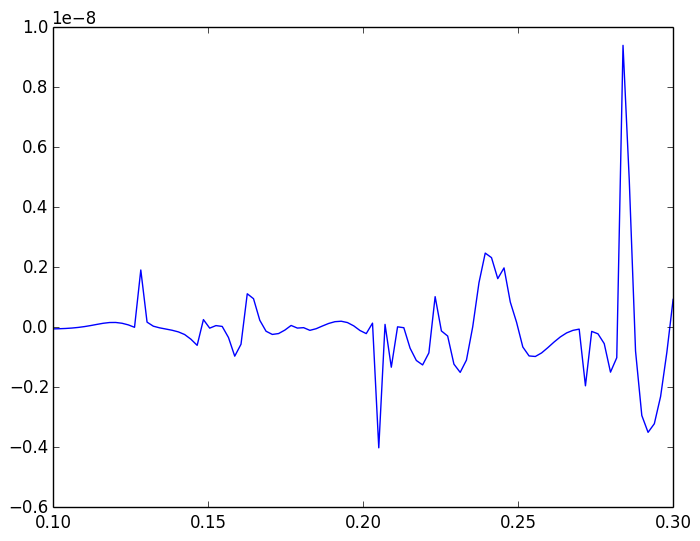

In [40]:
plot(freqs,(Is.^2));